In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

Shapes of the two volume datasets:
gt_instance_volume.shape: (420, 310, 724), dtype=uint16   
raw_input_volume.shape: (420, 310, 724), dtype=uint16   

RAM required to load the data in uint16: 0.18 GB
0.18 GB

Attributes: 
clipping_min_corner: [240  45  88], type=<class 'numpy.ndarray'>
name: first_assembly, type=<class 'str'>
raw_max: 65535, type=<class 'numpy.uint16'>
raw_min: 10194, type=<class 'numpy.uint16'>
relative_scale_to_artist: 1, type=<class 'numpy.int64'>
semantic_label_list: ['background' '47713' '47712' '32526' '32526' '32526' '2780' '2780' '2780'
 '2780' '2780' '2780' '2780' '2780' '32278' '32278' '6558' '6558' '6558'
 '6558' '6558' '6558' '6558' '6558' '32013' '32013' '32062' '32062'
 '32034' '32034' '3713' '3713' '32056' '32056' '75535' '44294' '4519'
 '4519' '32017' '32017' '32524'], type=<class 'numpy.ndarray'>
shift_to_place_meshes_in_volume: [-86.68928571 -38.475      -86.68928571], type=<class 'numpy.ndarray'>
streak_str_addition: x10y5z5, type=<class 'str'>
voxe

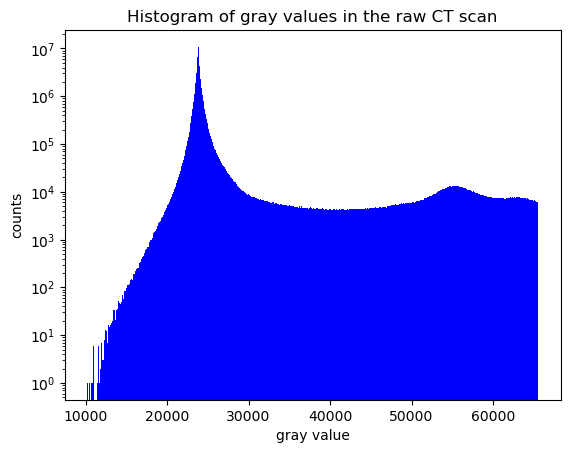

In [ ]:
# path to h5 data:
path_to_h5_data="<path_to_data>/first_assembly/first_assembly_x10y5z5/first_assembly_x10y5z5_dataset.h5"

with h5py.File(path_to_h5_data, 'r') as f:
    print("Shapes of the two volume datasets:")
    for key in f.keys():
        print(f"{key}.shape: {f[key].shape}, dtype={f[key].dtype}   ")

    # predict how much RAM will be required to load the data:
    print("\nRAM required to load the data in uint16:", np.round(np.prod(f[key].shape) * 2 / (1024 ** 3), 2), "GB")
    # check how much RAM it takes indeed:
    print(np.round(f['raw_input_volume'][:].nbytes / (1024 ** 3), 2), "GB")
    
    # print attributes of the file
    print("\nAttributes: ")
    for key in f.attrs.keys():
        print(f"{key}: {f.attrs[key]}, type={type(f.attrs[key])}")
        
    print("\nNumber of parts in the assembly:", len(f.attrs['semantic_label_list']) - 1)  # -1 because the zero label is 'background'
    print("Number of unique parts (i.e. parts in the catalogue):", len(set(f.attrs['semantic_label_list'])) - 1)  # -1 because the zero label is 'background'
    
    # check that the number of unique parts matches the number of stl files:
    stl_folder = os.path.join(os.path.dirname(os.path.dirname(path_to_h5_data)), 'stl_catalog')
    for semantic_label in f.attrs['semantic_label_list']:
        if semantic_label == "background":
            continue
        assert os.path.exists(os.path.join(stl_folder, f"{semantic_label}.stl")), \
            f"STL file for semantic label {semantic_label} does not exist in {stl_folder}!"
        
    assert len(set(f.attrs['semantic_label_list'])) == len(os.listdir(stl_folder)), \
        "Number of unique parts in the dataset does not match the number of STL files in the folder!"  # the background label is +1 on the RHS the first_assembly_info.json file + 1 on RHS

    print("\nThese checks may take some time for the larger volumes...")
    # check that GT instance segmentation is numbered from 0 to number of instances:
    unique_instance_labels = np.sort(np.unique(f['gt_instance_volume']))
    assert np.all(unique_instance_labels == np.arange(unique_instance_labels.shape[0])), \
        "GT instance segmentation labels are not numbered from 0 to number of instances!"
    
    # check that the length of the semantic_label_list matches the number of instances:
    assert len(f.attrs['semantic_label_list']) == unique_instance_labels.shape[0], \
        "Length of semantic_label_list does not match the number of instances in GT instance segmentation!"
    
    # plot a histrogram of gray values in the raw CT scan:
    plt.figure()
    plt.title("Histogram of gray values in the raw CT scan")
    plt.hist(f['raw_input_volume'][:].flatten(), color='blue', bins=1000)
    plt.xlabel("gray value")
    plt.ylabel("counts")
    plt.yscale("log")
    plt.show()